In [267]:
%reset -f
import sys
sys.path.append('/home/psimmerl/mds_analysis')

import pathlib

import math
import numpy as np
import numba as nb
from math import ceil, floor

from src.histo_utilities import std_color_list as SCL
# from src.helper_functions import alert, Table, weight_calc

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors, TRatioPlot

# **************** #

CTAU = 1000
# CTAUS = np.round(np.logspace(2, 4, 10), 0)
# CTAUS = np.round(np.logspace(1, 7, 55), 0)
CTAUS = np.round(np.logspace(1, 5, 30), 0)
if CTAU not in CTAUS:
    CTAUS = np.append(CTAUS, CTAU)
    CTAUS = np.sort(CTAUS)

# **************************** #
LOCAL_DIR = '/home/psimmerl/mds_analysis'
OUT_DIR = f'{LOCAL_DIR}/reports/weekly/2024-04-15'

# **** #
MET_CATEGORY = ('lt200', 'low', 'high')[1]
TAG_CATEGORY = ('csccsc', 'cscdt')[1]
CUTSET = ('l1', 'scs', 'ropt', 'roptDNN', 'roptDNN_bkgMC_plusBeamHalo', 'roptDNN_bkgOOTData')[1]
OOT = False#True#

SIZE_VAR = TAG_CATEGORY[3:]

FN_MC = f'{LOCAL_DIR}/data/processed/mc_{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_rdf.root'
# FN_MC = f'{LOCAL_DIR}/data/processed/mc_{TAG_CATEGORY}{"OOT" if OOT else ""}_{CUTSET}_{MET_CATEGORY}_rdf.root'
FN_R3 = f'{LOCAL_DIR}/data/processed/r3_{TAG_CATEGORY}{"OOT" if OOT else ""}_{CUTSET}_{MET_CATEGORY}_rdf.root'

# **** #
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# rt.gErrorIgnoreLevel = 1001  # rt.kInfo + 1
# rt.gROOT.SetBatch(True)
PI = rt.TMath.Pi()

# rt.EnableImplicitMT(4)
# print('Enabled ROOT\'s implicit multithreading (sometimes causes a crash)')

gc = []

# **************** #
print(f'{MET_CATEGORY=}')
print(f'{TAG_CATEGORY=}')
print(f'{CUTSET=}')
print(f'{OOT=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

# **************** #
rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
    #
    'mc_noMB1Veto' : RDataFrame('MuonSystem_flat', FN_MC.replace('_rdf','_noMB1Veto_rdf')),
    'r3_noMB1Veto' : RDataFrame('MuonSystem_flat', FN_R3.replace('_rdf','_noMB1Veto_rdf')),
    #
    'mc_noCSCJetVeto' : RDataFrame('MuonSystem_flat', FN_MC.replace('_rdf','_noCSCJetVeto_rdf')),
    'r3_noCSCJetVeto' : RDataFrame('MuonSystem_flat', FN_R3.replace('_rdf','_noCSCJetVeto_rdf')),
    #
    'mc_noDTJetVeto' : RDataFrame('MuonSystem_flat', FN_MC.replace('_rdf','_noDTJetVeto_rdf')),
    'r3_noDTJetVeto' : RDataFrame('MuonSystem_flat', FN_R3.replace('_rdf','_noDTJetVeto_rdf')),
    #
    'mc_noCSCMuonVeto' : RDataFrame('MuonSystem_flat', FN_MC.replace('_rdf','_noCSCMuonVeto_rdf')),
    'r3_noCSCMuonVeto' : RDataFrame('MuonSystem_flat', FN_R3.replace('_rdf','_noCSCMuonVeto_rdf')),
    #
    'mc_noDTMuonVeto' : RDataFrame('MuonSystem_flat', FN_MC.replace('_rdf','_noDTMuonVeto_rdf')),
    'r3_noDTMuonVeto' : RDataFrame('MuonSystem_flat', FN_R3.replace('_rdf','_noDTMuonVeto_rdf')),
    #
    'mc_noHaloVeto' : RDataFrame('MuonSystem_flat', FN_MC.replace('_rdf','_noHaloVeto_rdf')),
    'r3_noHaloVeto' : RDataFrame('MuonSystem_flat', FN_R3.replace('_rdf','_noHaloVeto_rdf')),
}

print('Events Read:')
for key, rdf in rdfs.items():
    if TAG_CATEGORY == 'csccsc':
        # rdf = rdf.Filter('tag_dR > 1.5')
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')

    if TAG_CATEGORY == 'cscdt':
        # rdf = rdf.Filter('tag_dPhi > 0.4')
        # print('!! FILTERING FOR tag_dPhi > 0.4 !!')
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf


MET_CATEGORY='low'
TAG_CATEGORY='cscdt'
CUTSET='scs'
OOT=False

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_cscdt_scs_low_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_cscdt_scs_low_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-04-15'

Events Read:


  mc = 1,296 (782.90)
  r3 = 283 (283.00)
  mc_noMB1Veto = 3,788 (2,288.29)
  r3_noMB1Veto = 1,190 (1,190.00)
  mc_noCSCJetVeto = 1,379 (833.04)
  r3_noCSCJetVeto = 300 (300.00)
  mc_noDTJetVeto = 1,296 (782.90)
  r3_noDTJetVeto = 283 (283.00)
  mc_noCSCMuonVeto = 1,353 (817.33)
  r3_noCSCMuonVeto = 302 (302.00)
  mc_noDTMuonVeto = 1,593 (962.32)
  r3_noDTMuonVeto = 310 (310.00)
  mc_noHaloVeto = 1,757 (1,061.39)
  r3_noHaloVeto = 386 (386.00)


In [268]:
1383.97/1370.68-1, 255/251-1

(0.009695917354889616, 0.015936254980079667)

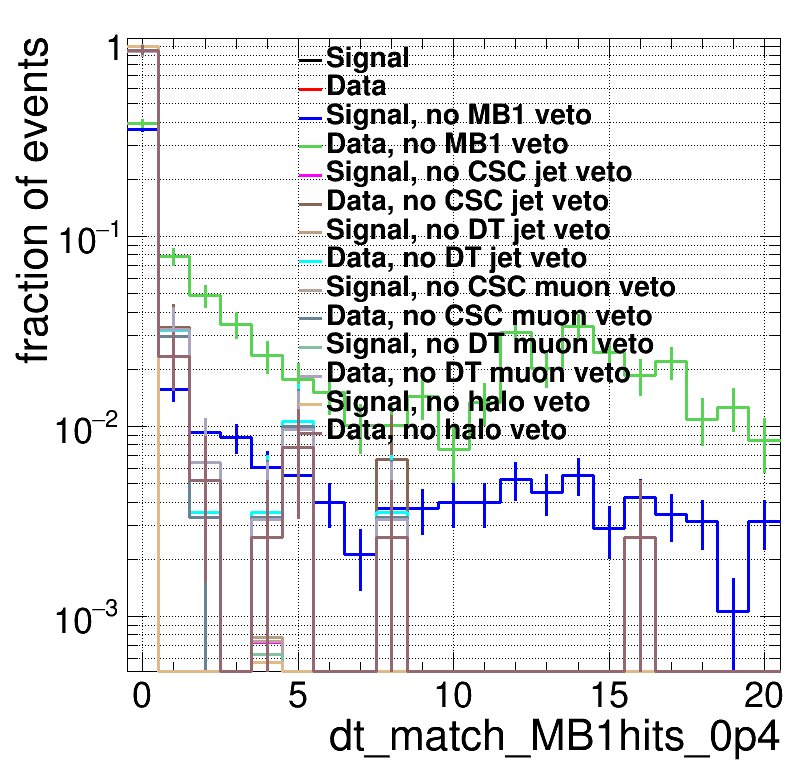

In [279]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

# legend = TLegend(0.17, 0.72, 0.44, 0.94) # Left
# legend = TLegend(0.37, 0.72, 0.64, 0.94) # Middle
legend = TLegend(0.37, 0.42, 0.64, 0.94) # Middle tall
# legend = TLegend(0.67, 0.72, 0.94, 0.94) # Right
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

# **** #
# xv = 'cscJetVetoPt'
# txy_label = f';{xv};fraction of events'
# form = (txy_label,50,0,200)
# logxyz = (False, True, False)

# xv = 'dtJetVetoPt'
# txy_label = f';{xv};fraction of events'
# form = (txy_label,50,0,200)
# logxyz = (False, True, False)

# xv = 'cscMuonVetoPt'
# txy_label = f';{xv};fraction of events'
# form = (txy_label,50,0,200)
# logxyz = (False, True, False)

# xv = 'dtMuonVetoPt'
# txy_label = f';{xv};fraction of events'
# form = (txy_label,50,0,200)
# logxyz = (False, True, False)

# xv = 'dtPhi'
# txy_label = f';{xv};fraction of events'
# form = (txy_label,20,-PI, PI)
# logxyz = (False, True, False)

# xv = 'cscDNN_bkgMC'
# txy_label = f';{xv};fraction of events'
# # form = (txy_label,50,0.8,1)
# form = (txy_label,25,0.9,1)
# logxyz = (False, True, False)

# xv = 'cscDNN_bkgMC_plusBeamHalo'
# txy_label = f';{xv};fraction of events'
# # form = (txy_label,50,0,1)
# form = (txy_label,20,0.8,1)
# logxyz = (False, True, False)

# xv = 'cscDNN_bkgOOTData'
# txy_label = f';{xv};fraction of events'
# # form = (txy_label,50,0,1)
# form = (txy_label,20,0.8,1)
# logxyz = (False, True, False)

xv = 'dt_match_MB1hits_0p4'
txy_label = f';{xv};fraction of events'
form = (txy_label,21,-0.5,20.5)
logxyz = (False, True, False)

# xv = 'dtNHitStation1'
# txy_label = f';{xv};fraction of events'
# form = (txy_label,21,-0.5,20.5)
# logxyz = (False, True, False)

# xv = 'tag_dPhi'
# txy_label = f';|#Delta#phi_{{CSC,DT}}|;fraction of events'
# form = (txy_label,32,0,PI)
# logxyz = (False, True, False)

# **** #

# h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,'weight').GetValue()
# h2 = rdfs['r3'].Histo1D(('Data',*form),xv,'weight').GetValue()
# hhs = [h1,h2]
# scales = [rdfs['mc'].Sum('weight').GetValue(), rdfs['r3'].Sum('weight').GetValue()]


hhs, scales = [], []
for k, n in [
        ('mc', 'Signal'),
        ('r3', 'Data'),
        ('mc_noMB1Veto', 'Signal, no MB1 veto'),
        ('r3_noMB1Veto', 'Data, no MB1 veto'),
        ('mc_noCSCJetVeto', 'Signal, no CSC jet veto'),
        ('r3_noCSCJetVeto', 'Data, no CSC jet veto'),
        ('mc_noDTJetVeto', 'Signal, no DT jet veto'),
        ('r3_noDTJetVeto', 'Data, no DT jet veto'),
        ('mc_noCSCMuonVeto', 'Signal, no CSC muon veto'),
        ('r3_noCSCMuonVeto', 'Data, no CSC muon veto'),
        ('mc_noDTMuonVeto', 'Signal, no DT muon veto'),
        ('r3_noDTMuonVeto', 'Data, no DT muon veto'),
        ('mc_noHaloVeto', 'Signal, no halo veto'),
        ('r3_noHaloVeto', 'Data, no halo veto'),
    ]:
    hhs.append(rdfs[k].Histo1D((n,*form),xv,'weight').GetValue())
    scales.append(rdfs[k].Sum('weight').GetValue())


# **** #
if logxyz[0]:
    canvas.cd(1).SetLogx()
if logxyz[1]:
    canvas.cd(1).SetLogy()
if logxyz[2]:
    canvas.cd(1).SetLogz()

hmin = min([h.GetMinimum(0) / s if s else 0 for h, s in zip(hhs, scales)])
hmax = max([h.GetMaximum() / s if s else 0 for h, s in zip(hhs, scales)])
# hmin, hmax = 0.1, max([h.GetMaximum() for h in hhs])
for ih, hh in enumerate(hhs):
    if hmax <= 1:
        hh.Scale(1/scales[ih])
    hh.SetMinimum(hmin*0.9)#0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('histE same')
    legend.AddEntry(hh, hh.GetName(), 'L')

# ratio = TRatioPlot(hhs[0], hhs[1])
# ratio.Draw()

# ratio.GetLowYaxis().SetNdivisions(505)
# ratio.GetLowerRefYaxis().SetTitle('Sig/Data')
# ratio.GetLowerRefGraph().SetLineWidth(3)
# ratio.GetLowerRefGraph().SetMinimum(0)
# ratio.GetLowerRefGraph().SetMaximum(3)

# ratio.SetSeparationMargin(0.01)
# ratio.SetLeftMargin(0.15)
# ratio.SetRightMargin(0.01)
# ratio.SetUpTopMargin(0.01)
# ratio.SetLowBottomMargin(0.4)

# l = TLine(1.0,0,1.0,hmax*1.1)
# l.SetLineColor(rt.kMagenta)
# l.SetLineWidth(3)
# l.Draw()

legend.Draw()
canvas.Draw()


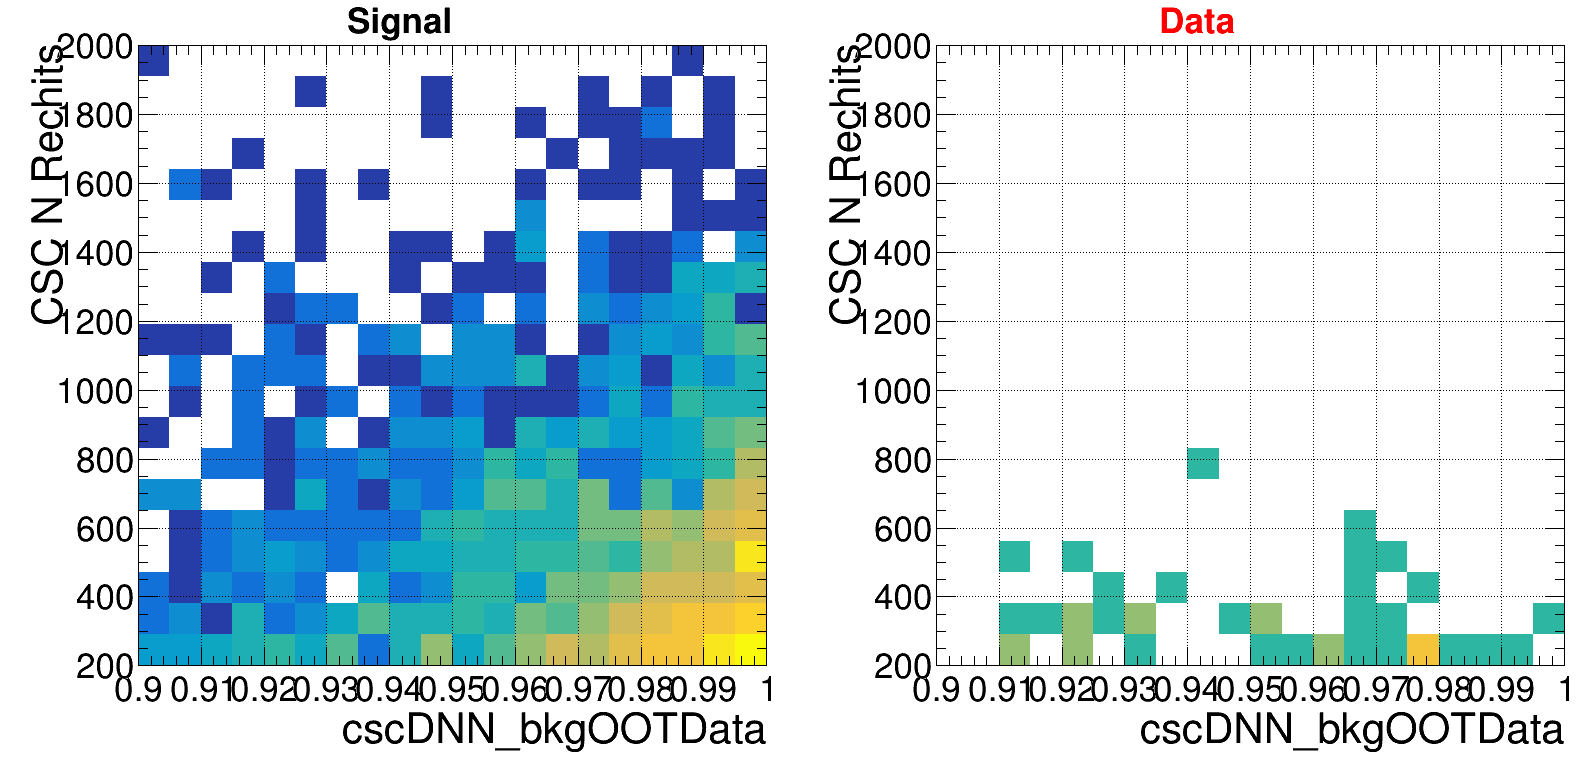

In [240]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)
# canvas.SetGrid()

# legend = TLegend(0.17, 0.72, 0.62, 0.94)
# legend.SetBorderSize(0)
# legend.SetFillColorAlpha(rt.kBlack, 0.2)
# legend.SetTextSize(0.04)
# legend.SetMargin(0.15)

lat = TLatex()
lat.SetTextSize(0.05)
lat.SetTextAlign(23)

# nb = 20
# xv, yv = 'met', 'tag_dPhi'
# txy_label = ';Missing E_{T} [GeV];|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.logspace(0, np.log10(300), nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (True, False, True)

# nb = 20
# xv, yv = 'cscMuonVetoPt', 'tag_dPhi'
# txy_label = ';CSC Muon Veto P_{T} [GeV];|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.logspace(-0.2, np.log10(300), nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (True, False, False)

# nb = 20
# xv, yv = 'dtMuonVetoPt', 'tag_dPhi'
# txy_label = ';DT Muon Veto P_{T} [GeV];|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.logspace(-0.2, np.log10(300), nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (True, False, False)

# nb = 20
# xv, yv = 'cscJetVetoPt', 'tag_dPhi'
# txy_label = ';CSC Jet Veto P_{T} [GeV];|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.logspace(0.9, np.log10(300), nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (True, False, False)

# nb = 20
# xv, yv = 'dtJetVetoPt', 'tag_dPhi'
# txy_label = ';DT Jet Veto P_{T} [GeV];|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.logspace(0.9, np.log10(300), nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (True, False, False)

# nb = 20
# xv, yv = 'met', 'dtSize'
# txy_label = ';Missing E_{T} [GeV];DT N_{Rechits};fraction of events'
# bins = (nb, np.logspace(0, np.log10(300), nb+1), nb, np.logspace(np.log10(40), np.log10(1000), nb+1))
# logxyz = (True, True, True)

# nb = 20
# xv, yv = 'cscEta', 'tag_dPhi'
# txy_label = ';#eta_{CSC};|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.linspace(-2, 2, nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'dtPhi', 'tag_dPhi'
# txy_label = ';#phi_{CSC};|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.linspace(-np.pi, np.pi, nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (False, False, True)


nb = 20
xv, yv = 'cscDNN_bkgMC', 'cscSize'
txy_label = ';cscDNN_bkgMC;CSC N Rechits;fraction of events'
bins = (nb, np.linspace(0.9, 1, nb+1), nb, np.linspace(200,2000,nb+1))
logxyz = (False, False, True)

nb = 20
xv, yv = 'cscDNN_bkgMC_plusBeamHalo', 'cscSize'
txy_label = ';cscDNN_bkgMC_plusBeamHalo;CSC N Rechits;fraction of events'
bins = (nb, np.linspace(0.9, 1, nb+1), nb, np.linspace(200,2000,nb+1))
logxyz = (False, False, True)

nb = 20
xv, yv = 'cscDNN_bkgOOTData', 'cscSize'
txy_label = ';cscDNN_bkgOOTData;CSC N Rechits;fraction of events'
# bins = (nb, np.linspace(0.0, 1, nb+1), nb, np.linspace(200,2000,nb+1))
bins = (nb, np.linspace(0.9, 1, nb+1), nb, np.linspace(200,2000,nb+1))
logxyz = (False, False, True)


# nb = 20
# xv, yv = 'cscDNN_bkgMC', 'dtSize'
# txy_label = ';cscDNN_bkgMC;DT N Rechits;fraction of events'
# bins = (nb, np.linspace(0.9, 1, nb+1), nb, np.linspace(50,100,nb+1))
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'cscDNN_bkgMC_plusBeamHalo', 'dtSize'
# txy_label = ';cscDNN_bkgMC_plusBeamHalo;DT N Rechits;fraction of events'
# bins = (nb, np.linspace(0.9, 1, nb+1), nb, np.linspace(50,100,nb+1))
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'cscDNN_bkgOOTData', 'dtSize'
# txy_label = ';cscDNN_bkgOOTData;DT N Rechits;fraction of events'
# # bins = (nb, np.linspace(0.0, 1, nb+1), nb, np.linspace(50,100,nb+1))
# bins = (nb, np.linspace(0.9, 1, nb+1), nb, np.linspace(50,100,nb+1))
# logxyz = (False, False, True)


# nb = 20
# xv, yv = 'tag_dPhi', 'dtSize'
# txy_label = ';|#Delta#phi_{CSC,DT}|;DT N_{Rechits};fraction of events'
# bins = (nb, np.linspace(0,PI,nb+1), nb, np.logspace(np.log10(40), np.log10(1000), nb+1))
# logxyz = (True, False, True)


# **** #

h1 = rdfs['mc'].Histo2D(('Signal',txy_label,*bins),xv,yv,'weight').GetValue()
h2 = rdfs['r3'].Histo2D(('Data',txy_label,*bins),xv,yv,'weight').GetValue()
hhs = [h1,h2]
scales = [rdfs['mc'].Sum('weight').GetValue(), rdfs['r3'].Sum('weight').GetValue()]

# hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
hmin = min([h.GetMinimum(0) / s if s else 0 for h, s in zip(hhs, scales)])
hmax = max([h.GetMaximum() / s if s else 0 for h, s in zip(hhs, scales)])
for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetGrid()
    if logxyz[0]:
        canvas.cd(ih + 1).SetLogx()
    if logxyz[1]:
        canvas.cd(ih + 1).SetLogy()
    if logxyz[2]:
        canvas.cd(ih + 1).SetLogz()

    if hmax < 1:
        hh.Scale(1/scales[ih])
    hh.SetMinimum(hmin*0.9)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('col')
    lat.SetTextColor(SCL[ih])
    lat.DrawLatexNDC(0.5, 1.0, hh.GetName())

# legend.Draw()
canvas.Draw()
